<a href="https://colab.research.google.com/github/AnnyshkaF/High-Performance-Lab/blob/main/task_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image blur

<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4010      0 --:--:-- --:--:-- --:--:--  4010
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 1.5 MB/s 
     |████████████████████████████████| 1.0 MB 45.0 MB/s 
+ set +ex
Installation succeeded!


In [2]:
import numpy as np 
import cupy as cp 
from matplotlib import pyplot as plt
from PIL import Image

size = 100 # image size
k = int(size / 100)
path = "logo.png"
image = np.array(Image.open(path).resize((size, size)).convert('L')) # open image an np.array
cmap = 'gray' # color map
 
# kernel parameters
k_border = 2 * k
k_size = 2 * k_border + 1

# cupy and numpy kernels
np_kernel = np.ones((k_size,k_size)) # square kernel for numpy
np_kernel /= np_kernel.sum() # values normalization
cp_kernel = cp.array(np_kernel) # same kernel as for numpy, but for cupy

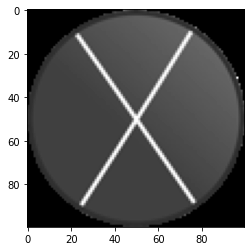

In [13]:
plt.imshow(image, cmap=cmap)

In [4]:
np_kernel.shape

(5, 5)

**Numpy and Cupy implementations**

In [6]:
# blur function (input parted image, kernel, input array type)
def np_blur(parted_image, kernel):
    kernel = np.ravel(kernel) # squeeze to 1 dimension
    out = np.dot(parted_image, kernel) # multiplication with kernel
    out = np.reshape(out, (size, size)) # reshape into initial size
    return out

def cp_blur(parted_image, kernel):
    kernel = cp.ravel(kernel)
    out = cp.dot(parted_image, kernel)
    out = cp.reshape(out, (size, size))
    return out

def image_partitioning(img):
    np_parted_image = np.zeros((size * size, k_size * k_size), dtype='float32')
    # for all pixels (i,j) exept borders
    for i in range(k_border, size - k_border):
        for j in range(k_border, size - k_border):
            # pack arrays into one dimension
            # consequtely save each kernel into array size*size, k_size,k_size
            np_parted_image[i * size + j] = img[i - k_border:i + k_border + 1, j - k_border:j + k_border + 1].flatten()
    return np_parted_image

In [8]:
# divide image into parts
np_parted_image = image_partitioning(image)
# same as numpy
cp_parted_image = cp.array(np_parted_image)

# numpy blur
np_blured = np_blur(np_parted_image, kernel = np_kernel)

# cupy blur
cp_blured = cp_blur(cp_parted_image, kernel = cp_kernel)

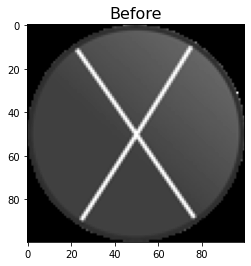

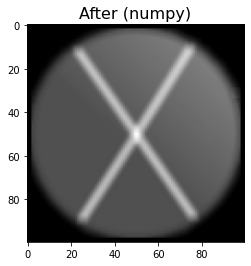

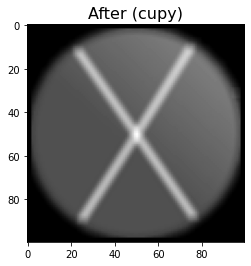

In [9]:
plt.title('Before', fontsize=16)
plt.imshow(image, cmap = cmap)
plt.show()
plt.title('After (numpy)', fontsize=16)
plt.imshow(np_blured.astype(np.uint8), cmap = cmap)
plt.show()
plt.title('After (cupy)', fontsize=16)
plt.imshow(cp.asnumpy(cp_blured).astype(np.uint8), cmap = cmap)
plt.show()

**Cupy version computation time**

In [10]:
%timeit -n 10 cp_blur(cp_parted_image, cp_kernel)

10 loops, best of 5: 85.1 µs per loop


**Numpy version computation time**

In [11]:
%timeit -n 10 np_blur(np_parted_image, np_kernel)

10 loops, best of 5: 470 µs per loop
